### Clustering von genetischen Daten in R

0. Preprocessing
1. Visualisierung von Clusteringmethoden
2. Visualisierung von Distanz-Matrix-Methoden

#### 1. Einlesen und Preprocessing der Daten:

In [1]:
source("https://bioconductor.org/biocLite.R") 
biocLite("genefilter")
library(genefilter)

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘genefilter’



The downloaded binary packages are in
	/var/folders/7c/4szph6ns2n9fc1nl9rc06n0m0000gn/T//RtmpvwnEhC/downloaded_packages


Old packages: 'curl'


Dieser Datensatz gibt mRNA Levels (Expressionslevels) diverser Gene im Verlauf des Zellzyklus wieder.
Durch die Selektion reduziert man von 82 auf 24 Datensätze;
Ein Boxplot hilft Vornormalisierung zu visualisieren:

[1] "Ursprünglicher Datensatz hat 6178 Datensätze mit 82 Merkmalen."

[1] "Gefilterter Datensatz hat 4381 Datensätze mit 24 Merkmalen."

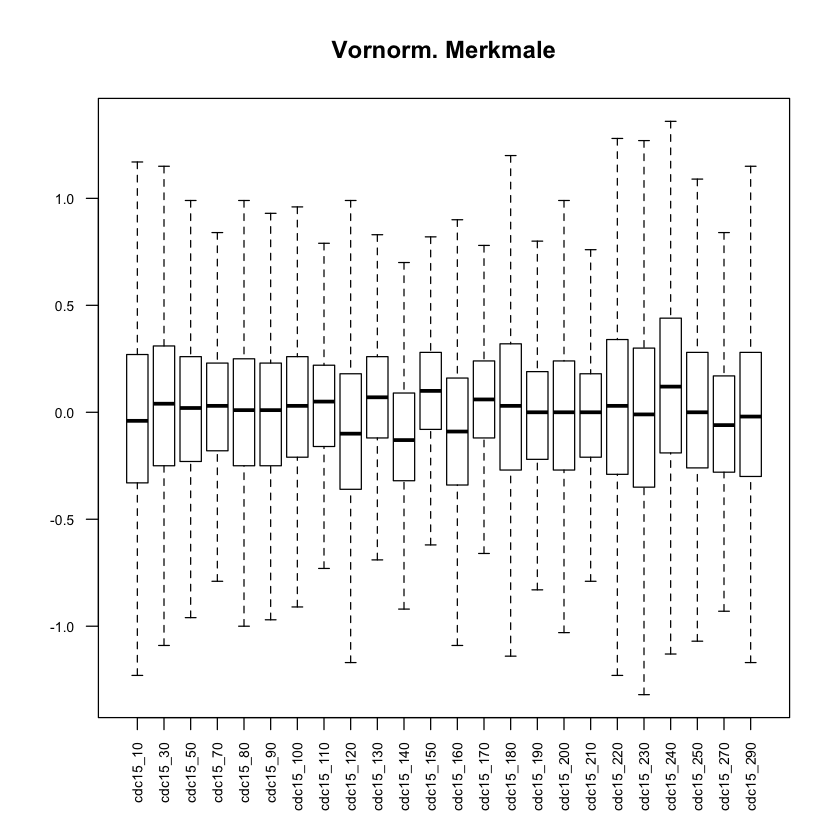

In [2]:
d<-read.table("combined.txt", sep="\t", header=T, row.names=1)
da<-data.frame(d[26:49])
dat<-na.omit(da)
sprintf("Ursprünglicher Datensatz hat %s Datensätze mit %s Merkmalen.", nrow(d), ncol(d))
sprintf("Gefilterter Datensatz hat %s Datensätze mit %s Merkmalen.", nrow(dat), ncol(dat))
boxplot(dat, outline=F, las=2, cex.axis=0.7, main="Vornorm. Merkmale")

#### Datenreduktion durch Filtern

In [3]:
percentage<-c(0.997)
sds<-rowSds(dat)
sel<-(sds>quantile(sds,percentage))
set<-dat[sel, ]
sprintf("Es verbleiben %s Datensätze.", nrow(set))

[1] "Es verbleiben 14 Datensätze."

#### 2. Visualisierung diverser Clusteringmethoden

In [4]:
allPlots <- function(distance_method, D_matrix) {
    par(mfrow=c(2,2))
    for (linkage_method in c("average","single","complete","ward.D")){
          hc<-hclust(D_matrix, method=c(linkage_method))
          linkage_title = paste0(distance_method,"/",linkage_method)
          plot(hc, labels=row.names(set), main=linkage_title)
    }
}

Alle Euclidian distance basierte:

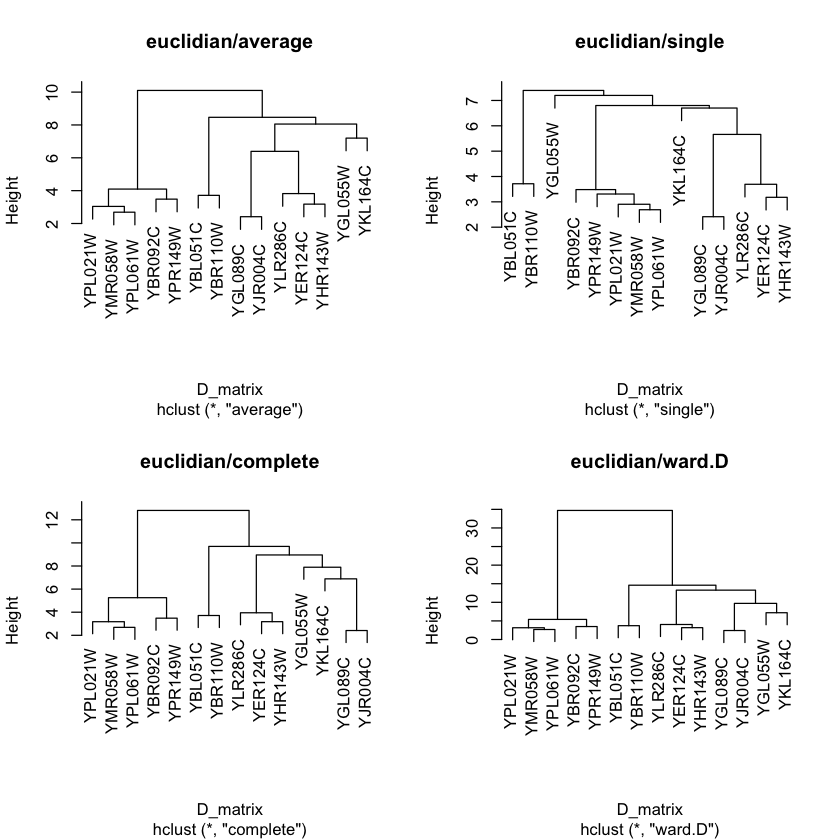

In [5]:
D_euclid<-dist(set, method="euclid")
allPlots("euclidian", D_euclid)

Unterschiede der Linkage Methoden werden bis zu einem gewissem Grad ersichtlich:
- Single Linkage bildet lange Ketten ("chaining phenomenon" - siehe "Stiegenform" beim mittleren Ast)
- Complete Linkage führt zu balancierteren Dendrogrammen, aufgrund der Wahl der maximalen Distanz zwischen Clusterpunkten
- Average Linkage (vgl. auch "Centroid linkage" -https://nlp.stanford.edu/IR-book/html/htmledition/centroid-clustering-1.html) nimmt minimale durchschnittliche Distanzen zweier Klassen als Merging-Kriterium - dadurch ergibt sich hier ebenfalls kein chaining phenomenon.
- Ward's Distance Linkage, auch manchmal Minimal Increase of Sum-of-Squares genannt, minimiert als Merging-Kriterum den Anstieg der Summe der Punkt-Clusterzentrum-Distanzen nach Zusammenfassen zweier Cluster; Ergibt hier relativ ähnliche Ergebnisse wie das Complete Linkage Clustering.

Alle Pearson-Distance basierten Clusterings:

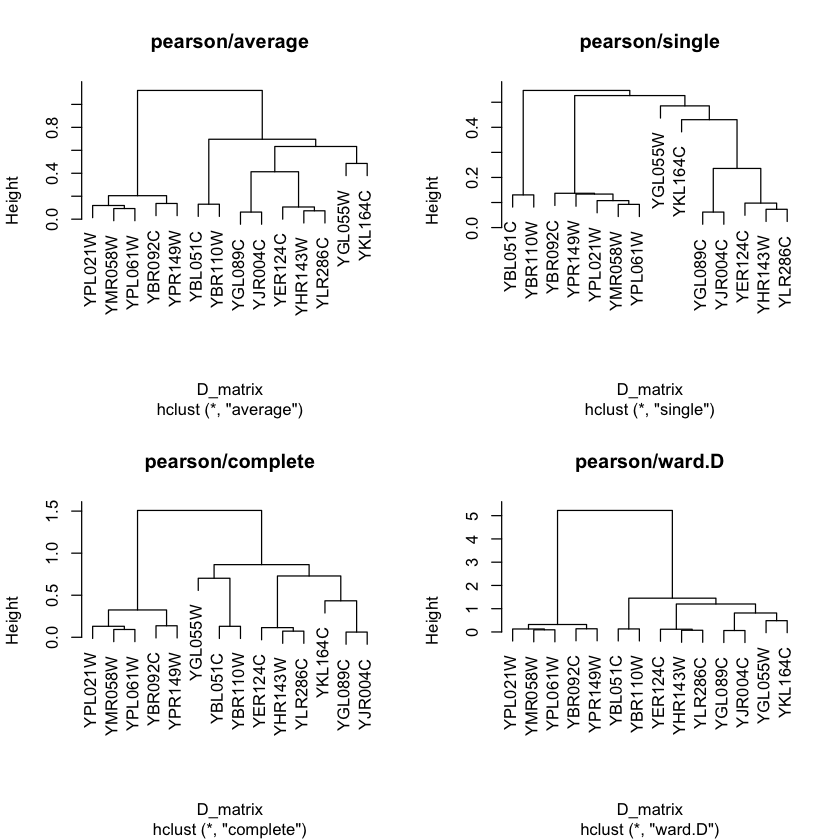

In [6]:
D_pearson<-as.dist(1-cor(t(set), method=c("pearson")))
allPlots("pearson", D_pearson)

Schliesslich alle Spearman-Distance basierten:

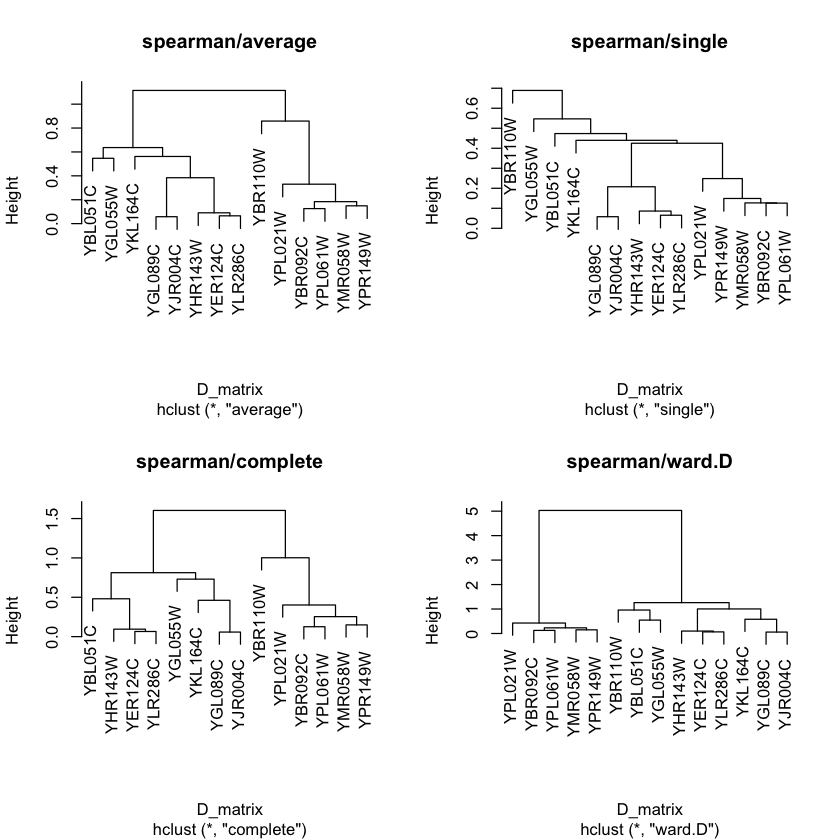

In [7]:
D_spearman<-as.dist(1-cor(t(set), method=c("spearman")))
allPlots("spearman", D_spearman)

#### 3. Visualisierung und Kommentare bez. Distanzmatrizen

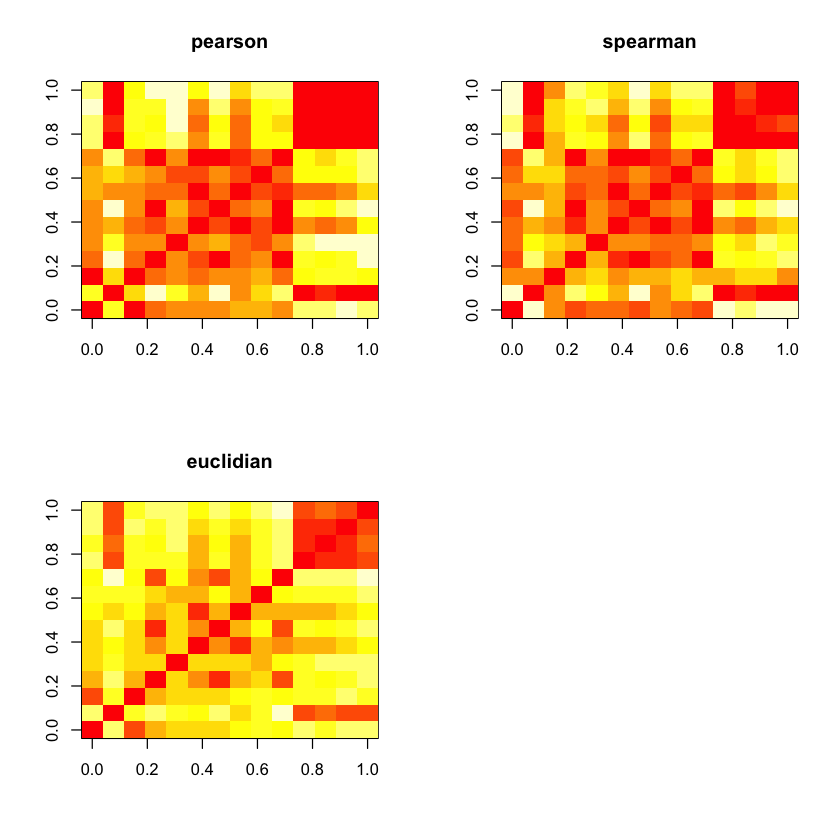

In [8]:
par(mfrow=c(2,2))
image(as.matrix(D_pearson),main="pearson")
image(as.matrix(D_spearman),main="spearman")
image(as.matrix(D_euclid), main="euclidian")

**Basics zu verschiedenen Distanzrechnungsmethoden**

Die Euklidische Distanz spiegelt reine geometrische Distanz wieder - sie ist nicht skalenunabhängig, und ist demnach laut Literatur im allgemeinen Gebrauch eher geeignet, Gene mit ähnlich großen Expressionslevels zu untersuchen (für diese und die folgenden Metrics war https://www.nature.com/articles/nbt1205-1499 eine Referenz).

Die Pearson-Distanz spiegelt Korrelationskoeffizienten zwischen zwei Vektoren wieder - sie ist skalenunabhängig, und würde Gene mit positiv korrelierenden Expressionlevels clustern (also ähnlicher Expressions-Verlaufsform während Zellzyklus. Pearson Squared Distanz würde auch anti-korrelierte Gene einbeziehen). Basiert auf linearen (direkt proportionalen) Beziehungen.

Die Spearman-Distanz spiegelt Rank-Korrelationskoeffizienten zwischen zwei Vektoren wieder - ist ebenfalls skalenunabhängig, im Gegensatz zu Pearson-Distanz wird eine monotonische aber nicht unbedingt lineare Beziehung angenommen: d.h. gemeinsames Clustering, wenn Genexpressionsverläufe zwar ähnliche (bzw. anti-korrelativ entgegengesetzte) Verläufe zeigen, aber nicht unbedingt immer lineare gemeinsame Größenänderungen aufweisen.

Eine kurze Google Scholar Suche suggeriert das die Pearson Distanz beim Gene-Clustering etwas populärer als Euclidian oder Spearman-Distanz ist (z.B. siehe ein Paper zu B-Lymphoma clustering als 'pars pro toto': https://www.nature.com/articles/35000501 - hier wurde Pearson-Distanz + Centroid linkage verwendet).

**Wie wirkt sich das auf die Darstellung der Distanzmatrizen oben aus?**

2 Unterschiede fallen als Folge dieser Distanz-Metric-Beschreibung auf:
1. Pearson & Spearman Distanzmaztrix zeigen aufgrund aufgrund Gewichtung der Korrelation bei mehreren Bereichen größere Unterschiede (stärker eingefärbte Punkte, siehe z.B. die ausgeprägte Mittelzone) als die Euclidische Distanz auf. Das macht Sinn, da klein-skalige Korrelationen bei der Euclid-Matrix nicht auffallen können während sie bei Korrelations-Metrix durchaus in den gleichen Größenbereich (z.b. [0,2] bei Pearson) 'komprimiert' werden.
2. Man würde erwarten, das die Spearman-Distanz Zusammenhänge etwas 'großzügiger' anerkennt als die Pearson-Distanz (auch nicht-lineare oder anti-korreliert bezogene Vektoren), also eventuell höhere Werte. In der Tat zeigt die Spearman-Distanz-Matrix hier mehrere Punkte-Paare, die bei der Pearson-Matrix als hell (nicht positiv korreliert) angezeigt werden, als dunkel - z.B. am oberen mittleren Rand.